In [1]:
# import dependencies
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
import gensim
from gensim.models import LdaModel
from gensim import models, corpora, similarities
import re
from nltk.stem.porter import PorterStemmer
import time
from nltk import FreqDist
from scipy.stats import entropy
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from subprocess import check_output

In [2]:
dataset=pd.read_excel('Train_set.xlsx')

In [3]:
dataset.head()

,title,text,label
0,This man claims to be Pakistan's answer to the...,This man claims to be Pakistan's answer to the...,Fake
1,Grade 20 officer steals Kuwaiti delegate’s wal...,ISLAMABAD: The government was exposed to extre...,Fake
2,Paid day-to-day expenses of PM House from my o...,Incarcerated former prime minister Nawaz Shari...,Fake
3,Rimal Khan and Her Alleged Relation With Imran...,"Rimal Ali, a female Transgender disowned by fa...",Fake
4,Major oil find near Pak-Iran border,KARACHI: Minister for Maritime Affairs and For...,Fake


In [4]:
def initial_clean(text):
    """
    Function to clean text of websites, email addresess and any punctuation
    We also lower case the text
    """
    text = re.sub("((\S+)?(http(s)?)(\S+))|((\S+)?(www)(\S+))|((\S+)?(\@)(\S+)?)", " ", text)
    text = re.sub("[^a-zA-Z ]", "", text)
    text = text.lower() # lower case the text
    text = nltk.word_tokenize(text)
    return text

stop_words = stopwords.words('english')
def remove_stop_words(text):
    """
    Function that removes all stopwords from text
    """
    return [word for word in text if word not in stop_words]

stemmer = PorterStemmer()
def stem_words(text):
    """
    Function to stem words, so plural and singular are treated the same
    """
    try:
        text = [stemmer.stem(word) for word in text]
        text = [word for word in text if len(word) > 1] 
    except IndexError: 
        pass
    return text

def apply_all(text):
    """
    This function applies all the functions above into one
    """
    return stem_words(remove_stop_words(initial_clean(text)))

In [5]:
# clean text and title and create new column "tokenized"
t1 = time.time()
dataset['tokenized'] = dataset['text'].apply(apply_all) + dataset['title'].apply(apply_all)
t2 = time.time()
print("Time to clean and tokenize", len(dataset), "articles:", (t2-t1)/60, "min")

Time to clean and tokenize 344 articles: 0.07656348546346028 min


In [6]:
# first get a list of all words
all_words = [word for item in list(dataset['tokenized']) for word in item]
# use nltk fdist to get a frequency distribution of all words
fdist = FreqDist(all_words)
len(fdist) # number of unique words

9063

In [7]:
# document length
dataset['doc_len'] = dataset['tokenized'].apply(lambda x: len(x))
doc_lengths = list(dataset['doc_len'])
dataset.drop(labels='doc_len', axis=1, inplace=True)

print("length of list:",len(doc_lengths),
      "\naverage document length", np.average(doc_lengths),
      "\nminimum document length", min(doc_lengths),
      "\nmaximum document length", max(doc_lengths))

length of list: 344 
average document length 212.625 
minimum document length 17 
maximum document length 895


In [8]:
dataset.head()

,title,text,label,tokenized
0,This man claims to be Pakistan's answer to the...,This man claims to be Pakistan's answer to the...,Fake,"[man, claim, pakistan, answer, hulkmardan, wei..."
1,Grade 20 officer steals Kuwaiti delegate’s wal...,ISLAMABAD: The government was exposed to extre...,Fake,"[islamabad, govern, expos, extrem, embarrass, ..."
2,Paid day-to-day expenses of PM House from my o...,Incarcerated former prime minister Nawaz Shari...,Fake,"[incarcer, former, prime, minist, nawaz, shari..."
3,Rimal Khan and Her Alleged Relation With Imran...,"Rimal Ali, a female Transgender disowned by fa...",Fake,"[rimal, ali, femal, transgend, disown, famili,..."
4,Major oil find near Pak-Iran border,KARACHI: Minister for Maritime Affairs and For...,Fake,"[karachi, minist, maritim, affair, foreign, af..."


In [9]:
newdataset=dataset.drop(['title','text'],axis=1)
newdataset

,label,tokenized
0,Fake,"[man, claim, pakistan, answer, hulkmardan, wei..."
1,Fake,"[islamabad, govern, expos, extrem, embarrass, ..."
2,Fake,"[incarcer, former, prime, minist, nawaz, shari..."
3,Fake,"[rimal, ali, femal, transgend, disown, famili,..."
4,Fake,"[karachi, minist, maritim, affair, foreign, af..."
5,Fake,"[islamabad, go, smoothli, till, pm, juli, resu..."
6,True,"[rawalpindi, contrari, report, circul, social,..."
7,Fake,"[sindh, high, court, shc, public, relat, offic..."
8,True,"[lahor, pti, chairman, imran, khan, said, kiss..."
9,Fake,"[outrag, mian, nawaz, sharif, statement, slow,..."


In [10]:
#X = newdataset.tokenized
#y = newdataset.label
#X = dataset.iloc[:, 1]
#y = dataset.iloc[:, 0]

In [11]:
y = dataset.label

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test= train_test_split(dataset['text'], y, test_size= 0.20, random_state= 0)

In [13]:
X_train.head()

49     As the investigation into Friday’s attack on t...
310    Major international news outlets earlier on Su...
325    Minister for Information and Broadcasting Chau...
122    ISLAMABAD – After an appeal made by Prime Mini...
167    ISLAMABAD: Pakistan Electronic Media Regulator...
Name: text, dtype: object

In [14]:
y_train.head()

49     True 
310     Fake
325     Fake
122     Fake
167     Fake
Name: label, dtype: object

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cross_validation import train_test_split
from nltk.corpus import stopwords

C:\Users\iwx499921\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [16]:
# Extracting features from text files count vectorizer
count_vect = CountVectorizer(stop_words='english')
X_train_counts = count_vect.fit_transform(X_train)
# Transform the test set 
X_test_counts  = count_vect.transform(X_test)
X_train_counts.shape

(275, 9196)

In [17]:
X_test_counts.shape

(69, 9196)

In [18]:
#1 logistic regression classifier 
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state= 0)
classifier.fit(X_train_counts, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [19]:
y_pred= classifier.predict(X_test_counts)

In [20]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)


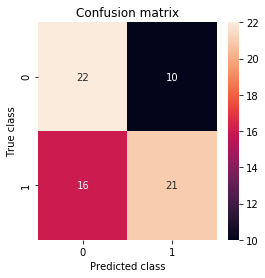

In [21]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [22]:
from sklearn.metrics import fbeta_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [23]:
fbeta_score(y_test, y_pred, average='weighted', beta=0.1 ,sample_weight=None)

0.6314768106904691

In [24]:
accuracy_score(y_test, y_pred, normalize=True)

0.6231884057971014

In [25]:
#Classification report logistic regression
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

       Fake       0.58      0.69      0.63        32
      True        0.68      0.57      0.62        37

avg / total       0.63      0.62      0.62        69



In [26]:
#2 Naive Bayes classifier 
from sklearn.naive_bayes import MultinomialNB

In [27]:
classifier = MultinomialNB(alpha=0.7)
classifier.fit(X_train_counts, y_train)

MultinomialNB(alpha=0.7, class_prior=None, fit_prior=True)

In [28]:
y_pred= classifier.predict(X_test_counts)
cm = confusion_matrix(y_test, y_pred)

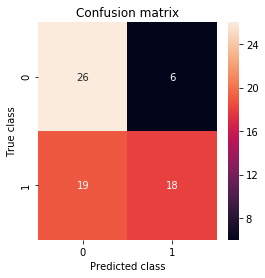

In [29]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [30]:
fbeta_score(y_test, y_pred, average='weighted', beta=0.1)


0.6687520830452035

In [31]:
accuracy_score(y_test, y_pred, normalize=True)

0.6376811594202898

In [32]:
#Classification report Naive Bayes
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

       Fake       0.58      0.81      0.68        32
      True        0.75      0.49      0.59        37

avg / total       0.67      0.64      0.63        69



In [33]:
#3 K Nearest Neighbors(KNN) 

In [34]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors= 5, metric = 'minkowski', p = 2)
classifier.fit(X_train_counts, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [35]:
y_pred= classifier.predict(X_test_counts)
cm = confusion_matrix(y_test, y_pred)

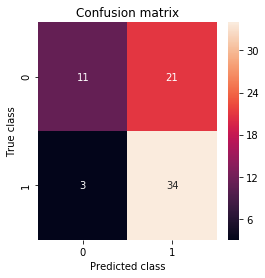

In [36]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [37]:
fbeta_score(y_test, y_pred, average='weighted', beta=0.1)

0.6923753463846389

In [38]:
accuracy_score(y_test, y_pred, normalize=True)

0.6521739130434783

In [39]:
#Classification report K Nearest Neighbors(KNN)
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

       Fake       0.79      0.34      0.48        32
      True        0.62      0.92      0.74        37

avg / total       0.70      0.65      0.62        69



In [40]:
#4 Support Vector Machine (SVM linear kernel)

In [41]:
from sklearn.svm import SVC
classifier = SVC(kernel = 'linear', random_state= 0)
classifier.fit(X_train_counts, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=0, shrinking=True,
  tol=0.001, verbose=False)

In [42]:
y_pred= classifier.predict(X_test_counts)
cm = confusion_matrix(y_test, y_pred)

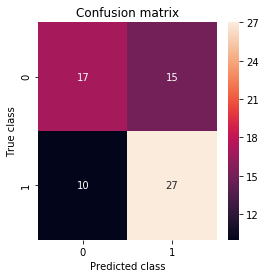

In [43]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [44]:
fbeta_score(y_test, y_pred, average='weighted', beta=0.1)

0.6365950308602992

In [45]:
accuracy_score(y_test, y_pred, normalize=True)

0.6376811594202898

In [46]:
#Support Vector Machine (SVM linear kernel)
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

       Fake       0.63      0.53      0.58        32
      True        0.64      0.73      0.68        37

avg / total       0.64      0.64      0.63        69



In [47]:
#5 Support Vector Machine (SVM Sigmoid kernel)

In [48]:
from sklearn.svm import SVC
classifier = SVC(kernel = 'sigmoid', random_state= 0)
classifier.fit(X_train_counts, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='sigmoid',
  max_iter=-1, probability=False, random_state=0, shrinking=True,
  tol=0.001, verbose=False)

In [49]:
y_pred= classifier.predict(X_test_counts)
cm = confusion_matrix(y_test, y_pred)

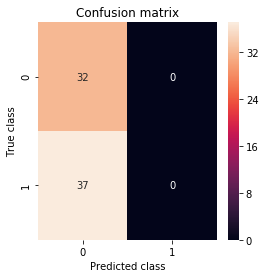

In [50]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [51]:
fbeta_score(y_test, y_pred, average='weighted', beta=24)

C:\Users\iwx499921\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.4628406298445286

In [52]:
accuracy_score(y_test, y_pred, normalize=True)

0.463768115942029

In [53]:
#Support Vector Machine (SVM Sigmoid kernel)
print(classification_report(y_test, y_pred))

C:\Users\iwx499921\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

       Fake       0.46      1.00      0.63        32
      True        0.00      0.00      0.00        37

avg / total       0.22      0.46      0.29        69



In [54]:
# No 6 Decision Tree Classification

In [156]:
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier(criterion = 'entropy', random_state= 0)
classifier.fit(X_train_counts, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

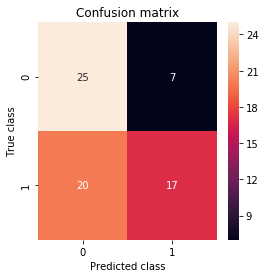

In [157]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [158]:
fbeta_score(y_test, y_pred, average='weighted', beta=0.1)

0.6361927542882198

In [159]:
accuracy_score(y_test, y_pred, normalize=True)

0.6086956521739131

In [160]:
#Decision Tree Classification
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

       Fake       0.56      0.78      0.65        32
      True        0.71      0.46      0.56        37

avg / total       0.64      0.61      0.60        69



In [161]:
#7 Random Forest Classification

In [162]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators= 10, criterion = 'entropy', random_state= 0)
classifier.fit(X_train_counts, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

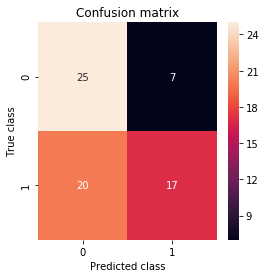

In [163]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [164]:
fbeta_score(y_test, y_pred, average='weighted', beta=24)

0.6085908499235586

In [165]:
accuracy_score(y_test, y_pred, normalize=True)

0.6086956521739131

In [166]:
#Random Forest Classification
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

       Fake       0.56      0.78      0.65        32
      True        0.71      0.46      0.56        37

avg / total       0.64      0.61      0.60        69



In [66]:
#Part 02 TF-IDF

In [67]:
# TF-IDF
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_test_tfidf = tfidf_transformer.fit_transform(X_test_counts)
X_train_tfidf.shape

(275, 9196)

In [68]:
X_test_tfidf.shape

(69, 9196)

In [69]:
#1 logistic regression classifier
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state= 0)
classifier.fit(X_train_tfidf, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [70]:
y_pred= classifier.predict(X_test_tfidf)

In [71]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[29,  3],
       [24, 13]], dtype=int64)

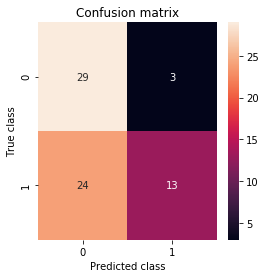

In [72]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [73]:
fbeta_score(y_test, y_pred, average='weighted', beta=0.1)

0.6848585868280568

In [74]:
accuracy_score(y_test, y_pred, normalize=True)

0.6086956521739131

In [75]:
#Decision Tree Classification TF-IDF
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

       Fake       0.55      0.91      0.68        32
      True        0.81      0.35      0.49        37

avg / total       0.69      0.61      0.58        69



In [76]:
# 2 Training Naive Bayes (NB) classifier on training data. TF-IDF
from sklearn.naive_bayes import MultinomialNB

In [77]:
classifier = MultinomialNB(0.6)
classifier.fit(X_train_tfidf, y_train)

MultinomialNB(alpha=0.6, class_prior=None, fit_prior=True)

In [78]:
y_pred= classifier.predict(X_test_tfidf)

In [79]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[29,  3],
       [25, 12]], dtype=int64)

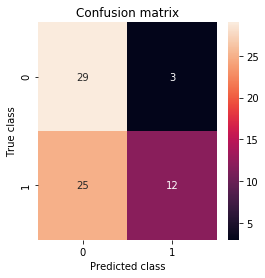

In [80]:
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [81]:
fbeta_score(y_test, y_pred, average='weighted', beta=0.1)

0.6729145500331781

In [82]:
accuracy_score(y_test, y_pred, normalize=True)

0.5942028985507246

In [83]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

       Fake       0.54      0.91      0.67        32
      True        0.80      0.32      0.46        37

avg / total       0.68      0.59      0.56        69



In [136]:
#TF-IDF
#K Nearest Neighbors(K-NN)

In [142]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors= 5, metric = 'minkowski', p = 2)
classifier.fit(X_train_tfidf, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [143]:
y_pred= classifier.predict(X_test_tfidf)

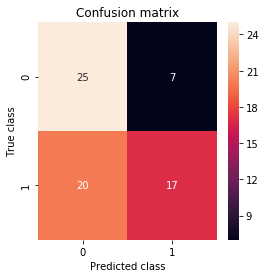

In [144]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [145]:
fbeta_score(y_test, y_pred, average='weighted', beta=0.1)

0.6361927542882198

In [146]:
accuracy_score(y_test, y_pred, normalize=True)

0.6086956521739131

In [147]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

       Fake       0.56      0.78      0.65        32
      True        0.71      0.46      0.56        37

avg / total       0.64      0.61      0.60        69



In [127]:
#TF_IDF
#Support Vector Machine (SVM) Linear

In [128]:
from sklearn.svm import SVC
classifier = SVC(kernel = 'linear', random_state= 0)
classifier.fit(X_train_tfidf, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=0, shrinking=True,
  tol=0.001, verbose=False)

In [129]:
y_pred= classifier.predict(X_test_tfidf)

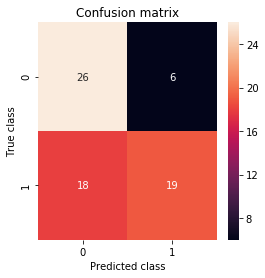

In [130]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [131]:
fbeta_score(y_test, y_pred, average='weighted', beta=0.1)

0.6803953814420846

In [132]:
accuracy_score(y_test, y_pred, normalize=True)

0.6521739130434783

In [133]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

       Fake       0.59      0.81      0.68        32
      True        0.76      0.51      0.61        37

avg / total       0.68      0.65      0.65        69



In [98]:
#SVM (sigmoid kernel)
#TF-IDF

In [99]:
from sklearn.svm import SVC
classifier = SVC(kernel = 'sigmoid', random_state= 0)
classifier.fit(X_train_tfidf, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='sigmoid',
  max_iter=-1, probability=False, random_state=0, shrinking=True,
  tol=0.001, verbose=False)

In [100]:
y_pred= classifier.predict(X_test_tfidf)

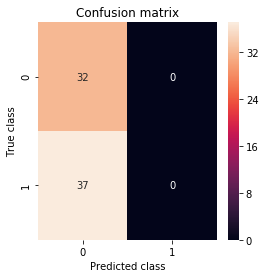

In [101]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [102]:
fbeta_score(y_test, y_pred, average='weighted', beta=0.5)

C:\Users\iwx499921\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.24091850178806698

In [103]:
accuracy_score(y_test, y_pred, normalize=True)

0.463768115942029

In [104]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

       Fake       0.46      1.00      0.63        32
      True        0.00      0.00      0.00        37

avg / total       0.22      0.46      0.29        69



C:\Users\iwx499921\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [105]:
#Decision Tree Classification
#TF-IDF

In [106]:
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier(criterion = 'entropy', random_state= 0)

In [107]:
classifier.fit(X_train_tfidf, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

In [108]:
y_pred= classifier.predict(X_test_tfidf)

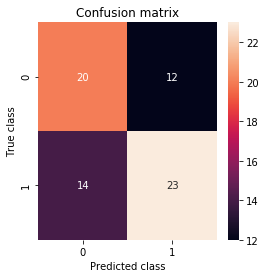

In [109]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [121]:
fbeta_score(y_test, y_pred, average='weighted', beta=0.1)

0.6447376261762765

In [122]:
accuracy_score(y_test, y_pred, normalize=True)

0.6086956521739131

In [112]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

       Fake       0.59      0.62      0.61        32
      True        0.66      0.62      0.64        37

avg / total       0.63      0.62      0.62        69



In [113]:
#Random Forest Classification
#TF-IDF

In [114]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators= 10, criterion = 'entropy', random_state= 0)

In [115]:
classifier.fit(X_train_tfidf, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [116]:
y_pred= classifier.predict(X_test_tfidf)

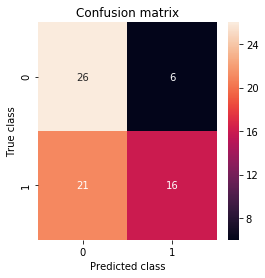

In [117]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [123]:
fbeta_score(y_test, y_pred, average='weighted', beta=0.1)

0.6447376261762765

In [124]:
accuracy_score(y_test, y_pred, normalize=True)

0.6086956521739131

In [125]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

       Fake       0.55      0.81      0.66        32
      True        0.73      0.43      0.54        37

avg / total       0.65      0.61      0.60        69

